In [1]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

In [12]:
tf.__version__

'2.3.1'

In [3]:
# Load data
mcycle = pd.read_csv('mcycle',delimiter='\t')
mcycle.times = (mcycle.times - mcycle.times.mean())/mcycle.times.std()
mcycle.accel = (mcycle.accel - mcycle.accel.mean())/mcycle.accel.std()

# Reshape to input format for network
times = np.expand_dims(mcycle.times.values, 1)
accel = np.expand_dims(mcycle.accel.values, 1)

**Multi-Quantile loss function:**

In [4]:
class MultiQuantileLoss(tf.keras.losses.Loss):
    
    def __init__(self, quantiles:list, **kwargs):
        super(MultiQuantileLoss, self).__init__(**kwargs)
        
        self.quantiles = quantiles

    def call(self, y_true, y_pred):
        
        # get quantile value
        q_id = int(y_pred.name.split("/")[1][1:])
        q = self.quantiles[q_id]
        
        # minimize quantile error
        q_error = tf.subtract(y_true, y_pred)
        q_loss = tf.reduce_mean(tf.maximum(q*q_error, (q-1)*q_error), axis=-1)
        return q_loss

**General function for creating the Milti-Quantile Neural Network (MQNN):**

In [9]:
def build_mqnn(quantiles:list, training_x_values:np.ndarray, internal_nodes:list = [32, 32],
               model_name:str = "mqnn", optimizer=None, input_normalization:bool = True):
    """
    Builds a MQNN
    :param quantiles: List of floats with quantiles to be trained. E.g. [0.25, 0.50, 0.75]
    :param training_x_values: 2-D numpy array with form [n-records, n-features]. NO categorical data expected.
    :param internal_nodes: List of integers describing internal nodes. E.g. [24, 12] means: two dense layers with 24 and 12 nodes, respectively.
    :param model_name: String to be used as model name. Default: 'mqnn'.
    :param optimizer: A tf.optimizers.Optimizer object to be used as optimizer. If not given, uses default Adam with training step of 0.001.
    :param input_normalization: Boolean. If True (default) includes a normalization step built in to the NN.
    """
    
    input_dim = training_x_values.shape[1]
    output_dim = len(quantiles)
    
    # define normalizer
    normalizer = preprocessing.Normalization()
    normalizer.adapt(training_x_values)
    
    # build model's node structure
    inputs = layers.Input(shape=input_dim)
    mdl = normalizer(inputs)
    for n_nodes in internal_nodes:
        mdl = layers.Dense(n_nodes, activation='relu')(mdl)
    outputs = [layers.Dense(1, activation='linear', name="q%d" % q_i)(mdl) for q_i in range(output_dim)]
    del input_dim, output_dim, mdl, normalizer
    
    # define optimizer and loss functions
    optm_func = tf.optimizers.Adam(learning_rate=0.001) if optimizer is None else optimizer
    loss_func = MultiQuantileLoss(quantiles=quantiles)
    
    # build and compile model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name=model_name)
    model.compile(optimizer=optm_func, loss=loss_func)
    
    return model

**Instantiate model:**

In [10]:
quantiles = [.1, .5, .9]
model = build_mqnn(quantiles, times, internal_nodes=[32, 32], model_name="mqnn")

**Train model:**

In [11]:
%%time
history = model.fit(
    times, accel, 
    epochs=2000,
    batch_size=32,
    verbose=0
)

Wall time: 5.6 s


**Plot graphic:**

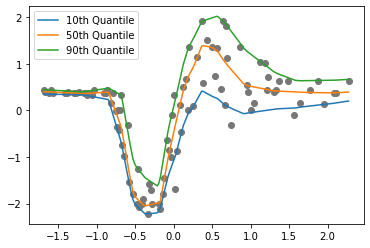

In [8]:
# Reshape data for plotting
test_times = np.expand_dims(np.linspace(times.min(),times.max(), 200), 1)
predictions = np.asarray(model.predict(test_times))
predictions = np.reshape(predictions, predictions.shape[0: 2])

# Call plitting functions
plt.scatter(times, accel, c="#777777")
for i, prediction in enumerate(predictions):
    plt.plot(test_times, prediction, label='{}th Quantile'.format(int(quantiles[i]*100)))
plt.legend()
plt.show()